In [13]:
import numpy as np
import numpy as np, scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline


# position and mass of basis (x,y,m)
a = 2 # bond length in ang
mlist = [2,4] # mass in 1e-26 kg

nx = 1
ny = 1

pos_uc = np.array([[0.0, 0.0, mlist[0]],
                   [0.0, -a, mlist[1]]])

nb = len(pos_uc)
natm = nb * nx * ny

latvec = np.array([[a,a],[a,-a]])
nq =100
iqstart = int(0.7*nq)

q = np.array([np.flip(np.linspace(0,2*np.pi/a/2,nq//2)),np.linspace(0,np.pi/a/2,nq//2)]).ravel()

#qq = np.linspace(0,np.pi/a/2,nq/2)
qq = np.array([np.zeros(nq//2,),np.linspace(0,np.pi/a/2,nq//2)]).ravel()


def generate_structure_2d(pos_uc,latvec,nx,ny):
    # diatomic cell
    # number of basis
    nb = pos_uc.shape[0]
    natm = nb * nx * ny
    
    # the atom positions of supercell
    pos = np.zeros((natm,3))
    count = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nb):
                pos[count,0:2] = pos_uc[k,0:2] + i * latvec[0,:] + j * latvec[1,:]
                pos[count,2] = pos_uc[k,2]
                count += 1
    return pos

def plot_structure(pos,m):
    npos = len(pos)
    nm = len(m)
    
    for i in range(npos):
        for j in range(nm):
            if (abs(float(m[j])-pos[i,2])<0.001):
                plt.scatter(pos[i,0],pos[i,1],c='C'+str(j),s=100)
    
    plt.axis('equal')
                

latvec_sc = np.array([latvec[0,:]*nx,latvec[1,:]*ny])
pos = generate_structure_2d(pos_uc,latvec,nx,ny)
#plot_structure(pos,mlist)

def gen_force_constant_supercell(pos,latvec_sc):
    npos = len(pos)
    pos_fc = np.zeros((npos*(2+1)*(2+1),3))
    
    count = 0
    for i in range(-1,2):
        for j in range(-1,2):
            for n in range(npos):
                pos_fc[count,0:2] = pos[n,0:2] \
                   + float(i)*latvec_sc[0,:]\
                   + float(j)*latvec_sc[1,:]
                pos_fc[count,2] = pos[n,2]
                count += 1
    return pos_fc

# we create a 3x3 supercell where central cell is the unit cell of interest
# we calculate dynamical matrix from the force constant
pos_fc = gen_force_constant_supercell(pos,latvec_sc)
#plot_structure(pos_fc,mlist)

# obtain the index of neighboring atoms for a atom
def gen_neighbor_list(pos,nns,latvec_sc):
    npos = len(pos)
    dr = np.zeros((2,))
    
    # neighborlist with dimensions (natm, number of neighbors)
    nlist = np.zeros((npos,nns))
    for i in range(npos):
        count = 0
        for j in range(npos):
            for m in range(-1,2):
                for n in range(-1,2):
                    dr = pos[i,0:2]-pos[j,0:2] +\
                    m* latvec_sc[0,:] + \
                    n* latvec_sc[1,:]
                    if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001:
                        nlist[i,count] = j
                        count += 1
                    elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                        nlist[i,count] = j
                        count += 1
    return nlist

def get_force_constant(pos,pos_fc,a):
    
    k1 = 100 # nereast neighbor force constant
    k2 = 100 #50 # second nearest neighbor force constant
    
    # number of atoms in unit cell
    nuc = len(pos)
    nsc = len(pos_fc)
    force_constant = np.zeros((nuc*2,natm*2*(2+1)*(2+1)))
    
    istart = int(1 * (3*nuc) + 1*nuc)
    dr = np.zeros((2,))
    
    for i in range(nuc):
        for j in range(nsc):
            dr = pos_fc[j,0:2] - pos_fc[i+istart,0:2]
            ix = 0 # x
            iy = 0 # x 
            if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001\
                 and abs(dr[1])<0.001:
                force_constant[2*i+ix,2*j+iy] = -k1
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 1 # y
            iy = 1 # y 
            if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001\
                 and abs(dr[0])<0.001:
                force_constant[2*i+ix,2*j+iy] = -k1
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 0 # x
            iy = 1 # y
            if abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]+dr[1])<0.001: # north west and south east
                force_constant[2*i+ix,2*j+iy] =  k2/2
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]-dr[1])<0.001: # south west and north east
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 1 # y
            iy = 0 # x
            if abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]+dr[1])<0.001: # north west and south east
                force_constant[2*i+ix,2*j+iy] =  k2/2
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]-dr[1])<0.001: # south west and north east
                force_constant[2*i+ix,2*j+iy] = -k2/2
    
    # acoustic sum rule
    for i in range(nuc):
        for ix in range(2):
            for iy in range(2):
                force_constant[2*i+ix,2*(istart+i)+iy] = -(np.sum(force_constant[2*i+ix,iy::2])-force_constant[2*i+ix,2*(istart+i)+iy])
    #print(force_constant.shape)
    #fig, axs = plt.subplots(ncols=1,figsize=(16,16))
    #matshow(axs,force_constant,title='$fc$') 
    
    return force_constant
    
    



# find the neighbor list for each atom
nlist = gen_neighbor_list(pos,8,latvec_sc)
force_constant = get_force_constant(pos,pos_fc,a)

# calculate the dynamical matrix
def gen_dyn(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    #print(pos[i,2]*pos[np.mod(j,nuc),2])
    #fig, axs = plt.subplots(ncols=1,figsize=(4,4))
    #matshow(axs,dyn.real,title='$fc$')

    return dyn

def gen_v1(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs = np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    #print(vel[0,:,:])
    dyn[:,:] = 0.5*(dyn[:,:]+np.transpose(dyn[:,:].conj()))
    vel[0,:,:] = 0.5*(vel[0,:,:]+np.transpose(vel[0,:,:].conj()))
    vel[1,:,:] = 0.5*(vel[1,:,:]+np.transpose(vel[1,:,:].conj()))

    [w,v] = la.eig(dyn)
    idx = np.argsort(w)
    w[:] = w[idx]
    v[:,:] = v[:,idx]
    #print(v)
    #print(vel[:,:,0]-vel[:,:,0].conj())
    #print(v[1,3]/abs(v[1,3]))
    #print(vel[:,:,1]-np.transpose(vel[:,:,1].conj()))
    #fig, axs = plt.subplots(ncols=1,figsize=(4,4))
    #matshow(axs,dyn.real,title='$fc$')
    for l in range(2): 
        for i in range(nd):
            for j in range(nd):
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))
                #if i==j:
                    #print(vs[l,i,j])

    #print('in',vs[0,0,0])
    return vs,v,np.sqrt(abs(w)),vel # /1e-26)/2/np.pi/1e12

def gen_v2(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs =  np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    dyn = 0.5*(dyn+np.transpose(dyn.conj()))
    vel[0,:,:] = 0.5*(vel[0,:,:]+np.transpose(vel[0,:,:].conj()))
    vel[1,:,:] = 0.5*(vel[1,:,:]+np.transpose(vel[1,:,:].conj()))

    [w,v] = la.eigh(dyn)


    for l in range(2):
        for i in range(nd):
            for j in range(nd):
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))
    return vs,v,np.sqrt(abs(w)),vel

def gen_v2_repul(force_constant,pos,pos_fc,q1,evo):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs =  np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    dyn = 0.5*(dyn+np.transpose(dyn.conj()))
    vel[0,:,:] = 0.5*(vel[0,:,:]+np.transpose(vel[0,:,:].conj()))
    vel[1,:,:] = 0.5*(vel[1,:,:]+np.transpose(vel[1,:,:].conj()))

    [w,v] = la.eigh(dyn)
    #print(round(np.dot(v[:,1].conj(),evo[:,1]),4),round(np.dot(v[:,2].conj(),evo[:,2]),4))

    if not(abs(np.dot(v[:,1].conj(),evo[:,1]))>0.8 and abs(np.dot(v[:,2].conj(),evo[:,2]))>0.8):
        w[1:3] = w[2:0:-1]
        v[:,1:3] = v[:,2:0:-1]


    for l in range(2):
        for i in range(nd):
            for j in range(nd):
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))
    return vs,v,np.sqrt(abs(w)),vel

def cal_phonon(dyn):
    [w,v] = la.eig(dyn)
    return w

def continuous_ev(datav,dataev):
    signs = np.zeros((dataev.shape[1],))
    dev = np.zeros((dataev.shape[1],),dtype=complex)
    datav1 = np.zeros(datav.shape,dtype=complex)
    dataev1 = np.zeros(dataev.shape,dtype=complex)
    dataev1[:,:,:] = dataev[:,:,:] 
    datav1[:,:,:,:] = datav[:,:,:,:]
    for i in range(2,nq-1):
        signs[:] = 1.0
        for j in range(dataev1.shape[1]):
            dev[:] = dataev1[i,:,j]-dataev1[i-1,:,j]
            if np.sqrt(np.dot(dev.conj(),dev))>0.2:
                signs[j] = -1
        for j in range(dataev1.shape[1]):
            dataev1[i,:,j] = signs[j]*dataev1[i,:,j]
        for j in range(datav1.shape[1]):
            for k in range(datav1.shape[2]):
                #print(signs[j]*signs[k])
                datav1[i,0,j,k] = signs[j]*datav1[i,0,j,k]*signs[k]
                datav1[i,1,j,k] = signs[j]*datav1[i,1,j,k]*signs[k]
    return datav1,dataev1

def plotting1():

    data = np.zeros((nq,4))
    datav = np.zeros((nq,2,4,4),dtype=complex)
    datavel = np.zeros((nq,2,4,4),dtype=complex)
    dataev = np.zeros((nq,4,4),dtype=complex)
 
    for i in range(nq):
        datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:] = gen_v1(force_constant,pos,pos_fc,np.array([q[i],qq[i]])) #/1e-26
        #data[i,:] = np.sort(np.sqrt(w.real)/2/np.pi/1e12) # in THz
    #print(datav[:,0,0,0])
    #datav,dataev = continuous_ev(datav,dataev)
    '''
    plt.figure()
    for i in range(4):
        plt.plot(data[:,i],label=str(i+1))
    plt.legend()

    plt.figure()
    for i in range(4):
        for j in range(4):
            if i == j:
                plt.plot(q[1:], datav[1:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    plt.figure()
    for i in range(4):
        for j in range(4):
            if i != j and i == 0:
                plt.plot(q[1:], datav[1:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    #plt.figure(figsize=(8,8))
    #for i in range(4):
    #    for j in range(4):
    #        if i == j:
    #            plt.plot(q[1:], datav[1:,i,j,1].real,'b',label=str(i+1)+str(j+1))
    #plt.legend()
    #print(dataev[11,:,:])
    #print(datav[11,:,:,0])
    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,0].real)
    plt.plot(q[1:-2],dataev[1:-2,2,0].real)
    plt.plot(q[1:-2],dataev[1:-2,0,0].real)
    plt.plot(q[1:-2],dataev[1:-2,3,0].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,1].real)
    plt.plot(q[1:-2],dataev[1:-2,2,1].real)
    plt.plot(q[1:-2],dataev[1:-2,0,1].real)
    plt.plot(q[1:-2],dataev[1:-2,3,1].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,2].real)
    plt.plot(q[1:-2],dataev[1:-2,2,2].real)
    plt.plot(q[1:-2],dataev[1:-2,0,2].real)
    plt.plot(q[1:-2],dataev[1:-2,3,2].real)
    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,3].real)
    plt.plot(q[1:-2],dataev[1:-2,2,3].real)
    plt.plot(q[1:-2],dataev[1:-2,0,3].real)
    plt.plot(q[1:-2],dataev[1:-2,3,3].real)
    #plt.plot(q,dataev[:,2,0].imag)

    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,1].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,2].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,3].imag)
    '''
    
 
    return datav,dataev,data,datavel
def plotting2():
    data = np.zeros((nq,4))
    datav = np.zeros((nq,2,4,4),dtype=complex)
    datavel = np.zeros((nq,2,4,4),dtype=complex)
    dataev = np.zeros((nq,4,4),dtype=complex)
    for i in range(nq):
        if i<iqstart:
            datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:] = gen_v2(force_constant,pos,pos_fc,np.array([q[i],qq[i]])) #/1e-26
        else:
            datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:]  = gen_v2_repul(force_constant,pos,pos_fc,np.array([q[i],qq[i]]),dataev[i-1,:,:])
    datav,dataev = continuous_ev(datav,dataev)

    '''
    plt.figure()
    for i in range(4):
        plt.plot(data[:,i],label=str(i+1))
    plt.legend()

    plt.figure()
    for i in range(4):
        for j in range(4):
            if i == j:
                plt.plot(q[1:], datav[1:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    plt.figure()
    for i in range(4):
        for j in range(4):
            if i != j and i == 0:
                plt.plot(q[1:], datav[1:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    #plt.figure(figsize=(8,8))
    #for i in range(4):
    #    for j in range(4):
    #        if i == j:
    #            plt.plot(q[1:], datav[1:,i,j,1].real,'b',label=str(i+1)+str(j+1))
    #plt.legend()
    #print(dataev[11,:,:])
    #print(datav[11,:,:,0])

    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,0].real)
    plt.plot(q[1:-2],dataev[1:-2,2,0].real)
    plt.plot(q[1:-2],dataev[1:-2,0,0].real)
    plt.plot(q[1:-2],dataev[1:-2,3,0].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,1].real)
    plt.plot(q[1:-2],dataev[1:-2,2,1].real)
    plt.plot(q[1:-2],dataev[1:-2,0,1].real)
    plt.plot(q[1:-2],dataev[1:-2,3,1].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,2].real)
    plt.plot(q[1:-2],dataev[1:-2,2,2].real)
    plt.plot(q[1:-2],dataev[1:-2,0,2].real)
    plt.plot(q[1:-2],dataev[1:-2,3,2].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,3].real)
    plt.plot(q[1:-2],dataev[1:-2,2,3].real)
    plt.plot(q[1:-2],dataev[1:-2,0,3].real)
    plt.plot(q[1:-2],dataev[1:-2,3,3].real)
    #plt.plot(q,dataev[:,2,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,1].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,2].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,3].imag)
    '''

    return datav,dataev,data,datavel


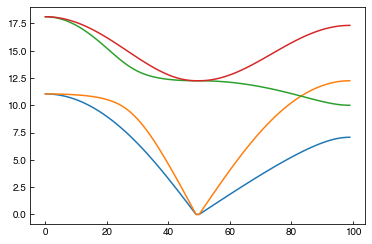

<Figure size 432x288 with 0 Axes>

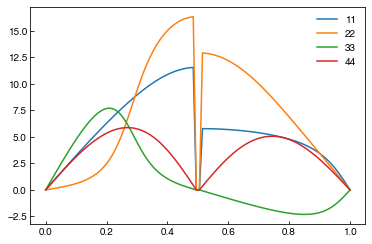

In [15]:
datav1 = np.zeros((nq,2,4,4),dtype=complex)
datav2 = np.zeros((nq,2,4,4),dtype=complex)
datav1,dataev1,d1,dvel1 = plotting1() 
datav2,dataev2,d2,dvel2 = plotting2()


datav3 = np.zeros(dvel2.shape,dtype=complex)

for i in range(datav1.shape[0]):
    for l in range(2):
        for j in range(4):
            for k in range(4):
            #datav3[i,0,j,k] = np.dot(dataev2[i,:,j].conj(),np.dot(dvel2[i,0,:,:],dataev2[i,:,k]))\
            #                /2/np.sqrt(d2[i,j]*d2[i,k])
                #print(np.dot(dataev1[i,:,j].conj(),np.dot(dvel1[i,0,:,:],dataev1[i,:,k]))/2/np.sqrt(d1[i,j]*d1[i,k]))
                datav3[i,l,j,k] = np.dot(dataev1[i,:,j].conj(),np.dot(dvel1[i,l,:,:],dataev1[i,:,k]))\
                            /2/np.sqrt(d1[i,j]*d1[i,k])
plt.figure()
for i in range(4):
    plt.plot(d2[:,i])
plt.figure()
#for i in range(4):
#    plt.plot(d2[1:nq,i]-d1[0:nq-1,i])
#plt.figure(figsize=(7,7))

#for i in range(4):
#    for j in range(4):
#        #if i != j and i ==1:
#        if i==j:
#            plt.plot(np.linspace(0,1,nq),datav3[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'  
#plt.legend()
#plt.figure(figsize=(7,7))
#plt.plot(np.linspace(0,1,nq),datav2[:,0,0,0].real,'.',label=str(i+1)+str(j+1)) # 'b'                

#for i in range(4):
#    for j in range(4):
#        if i == j:
#            plt.plot(np.linspace(0,1,nq),datav1[:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b' 
plt.figure()
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(np.linspace(0,1,nq),datav2[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend()
#plt.figure(figsize=(7,7))
#for i in range(4):
#    for j in range(4):
#        if i != j:
#            aa = datav2[:,1,i,j].real
#            plt.plot(np.linspace(0,1,len(aa)),dvel1[:,1,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'    